In [7]:
# ============================
# Imports
# ============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
import sqlite3

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim

plt.style.use("seaborn-v0_8")

In [35]:
# ============================
# Configuration
# ============================
start_date = "2025-05-01"
sequence_length = 30      # number of past days to look at
train_ratio = 0.8         # 80% train, 20% test
num_epochs = 200
learning_rate = 1e-3
hidden_size = 64
num_layers = 2
dropout = 0.2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [36]:
# ============================
# 1. Load NVDA from SQLite
# ============================
project_root = Path().resolve().parent          # NEWALGOTRADE
db_path = project_root / "data" / "processed" / "NVDA_proc.sqlite"

print("DB path:", db_path)
print("Exists:", db_path.exists())
if not db_path.exists():
    raise FileNotFoundError(f"Database not found at {db_path}")

conn = sqlite3.connect(str(db_path))

# List tables once (to see names)
tables = pd.read_sql(
    "SELECT name FROM sqlite_master WHERE type='table';",
    conn
)
print("Tables in DB:")
print(tables)

# TODO: set this explicitly once you know it
table_name = tables["name"].iloc[0]   # e.g. "prices" or "nvda_prices"
print("Using table:", table_name)

# Inspect columns once to see exact names
cols = pd.read_sql(f"PRAGMA table_info({table_name});", conn)
print("Columns in table:")
print(cols)

# ====== USE REAL COLUMN NAMES: Date and Close ======
df = pd.read_sql(
    f"""
    SELECT Date, Close
    FROM {table_name}
    WHERE Date >= ?
    ORDER BY Date;
    """,
    conn,
    params=(start_date,),
    parse_dates=["Date"],    # parse the Date column as datetime
)
conn.close()

# Use Date as index and keep Close as the price column
df.set_index("Date", inplace=True)    # index is now the timestamp
# Column is already named "Close", no need to rename, but you could standardize:
# df.rename(columns={"Close": "Close"}, inplace=True)

close_prices = df[["Close"]].dropna()
ticker = "NVDA"

print(close_prices.head())
print("Total rows:", len(close_prices))

DB path: C:\Users\soltv\Documents\GitHub\newalgotrade\data\processed\NVDA_proc.sqlite
Exists: True
Tables in DB:
   name
0  NVDA
Using table: NVDA
Columns in table:
   cid    name       type  notnull dflt_value  pk
0    0   Price       TEXT        0       None   0
1    1   Close       TEXT        0       None   0
2    2    High       TEXT        0       None   0
3    3     Low       TEXT        0       None   0
4    4    Open       TEXT        0       None   0
5    5  Volume       TEXT        0       None   0
6    6    Date  TIMESTAMP        0       None   0
                         Close
Date                          
2025-05-01  111.59595489501953
2025-05-02    114.485595703125
2025-05-05  113.80567932128906
2025-05-06  113.52571868896484
2025-05-07  117.04527282714844
Total rows: 143


In [37]:
# ============================
# 2. Scaling
# ============================
scaler = StandardScaler()
close_scaled = scaler.fit_transform(close_prices.values)   # shape (N, 1)

# ============================
# 3. Sequence creation
# ============================
def create_sequences(series: np.ndarray, window: int):
    """
    series: shape (N, 1)
    window: number of time steps in the input sequence

    Returns:
        X: shape (N - window, window, 1)
        y: shape (N - window, 1)
    """
    X, y = [], []
    for i in range(len(series) - window):
        x_i = series[i : i + window]      # window x 1
        y_i = series[i + window]          # 1 x 1
        X.append(x_i)
        Y = y_i
        y.append(y_i)
    return np.array(X), np.array(y)

X_all, y_all = create_sequences(close_scaled, sequence_length)
print("X_all shape:", X_all.shape)   # (num_samples, seq_len, 1)
print("y_all shape:", y_all.shape)   # (num_samples, 1)

# ============================
# 4. Train / test split
# ============================
num_samples = X_all.shape[0]
train_size = int(num_samples * train_ratio)

X_train_np = X_all[:train_size]
y_train_np = y_all[:train_size]
X_test_np  = X_all[train_size:]
y_test_np  = y_all[train_size:]

# ============================
# 5. Tensors
# ============================
X_train = torch.from_numpy(X_train_np).float().to(device)
y_train = torch.from_numpy(y_train_np).float().to(device)
X_test  = torch.from_numpy(X_test_np).float().to(device)
y_test  = torch.from_numpy(y_test_np).float().to(device)

print("Train samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])

# ============================

X_all shape: (113, 30, 1)
y_all shape: (113, 1)
Train samples: 90
Test samples: 23


In [38]:
# 6. LSTM model
# ============================
class PriceLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)

        out, _ = self.lstm(x, (h0, c0))     # (batch, seq_len, hidden_size)
        last_out = out[:, -1, :]            # (batch, hidden_size)
        pred = self.fc(last_out)            # (batch, 1)
        return pred

model = PriceLSTM(
    input_size=1,
    hidden_size=hidden_size,
    num_layers=num_layers,
    dropout=dropout,
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# ============================
# 7. Training loop
# ============================
model.train()
for epoch in range(1, num_epochs + 1):
    optimizer.zero_grad()
    preds = model(X_train)
    loss = criterion(preds, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 25 == 0 or epoch == 1:
        print(f"Epoch {epoch:4d}/{num_epochs}, Loss: {loss.item():.6f}")

# ============================
# 8. Evaluation
# ============================
model.eval()
with torch.no_grad():
    train_pred = model(X_train).cpu().numpy()
    test_pred  = model(X_test).cpu().numpy()

y_train_true = y_train.cpu().numpy()
y_test_true  = y_test.cpu().numpy()

train_pred_price = scaler.inverse_transform(train_pred)
test_pred_price  = scaler.inverse_transform(test_pred)
y_train_price    = scaler.inverse_transform(y_train_true)
y_test_price     = scaler.inverse_transform(y_test_true)

train_rmse = root_mean_squared_error(y_train_price, train_pred_price)
test_rmse  = root_mean_squared_error(y_test_price,  test_pred_price)

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test  RMSE: {test_rmse:.4f}")

Epoch    1/200, Loss: 0.310288
Epoch   25/200, Loss: 0.085048
Epoch   50/200, Loss: 0.033244
Epoch   75/200, Loss: 0.031740
Epoch  100/200, Loss: 0.028105
Epoch  125/200, Loss: 0.028281
Epoch  150/200, Loss: 0.024443
Epoch  175/200, Loss: 0.024825
Epoch  200/200, Loss: 0.021227
Train RMSE: 3.2059
Test  RMSE: 11.0513


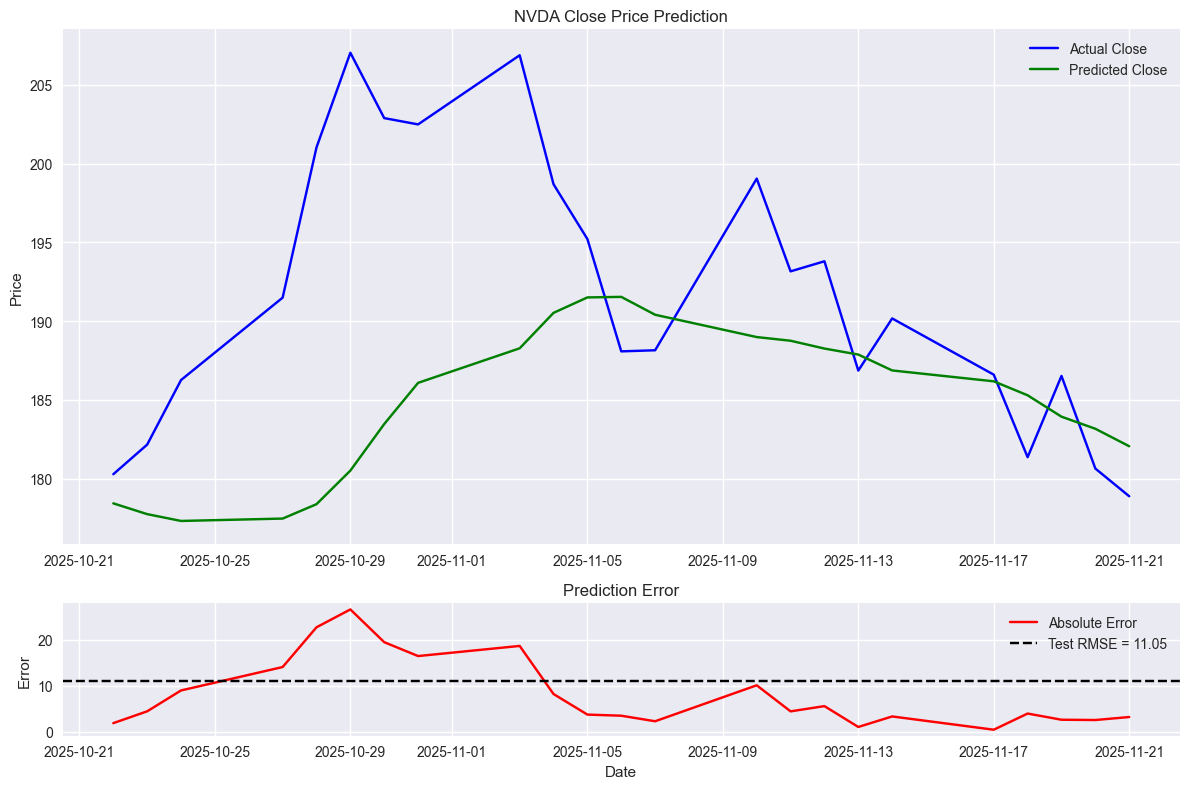

In [39]:
# ============================
# 9. Plot predictions (test)
# ============================
test_start_index = len(close_prices) - len(y_test_price)
test_dates = close_prices.index[test_start_index:]

fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(4, 1)

ax1 = fig.add_subplot(gs[:3, 0])
ax1.plot(test_dates, y_test_price.flatten(), color="blue", label="Actual Close")
ax1.plot(test_dates, test_pred_price.flatten(), color="green", label="Predicted Close")
ax1.set_title(f"{ticker} Close Price Prediction")
ax1.set_ylabel("Price")
ax1.legend()

ax2 = fig.add_subplot(gs[3, 0], sharex=ax1)
abs_error = np.abs(y_test_price - test_pred_price).flatten()
ax2.plot(test_dates, abs_error, color="red", label="Absolute Error")
ax2.axhline(test_rmse, color="black", linestyle="--",
            label=f"Test RMSE = {test_rmse:.2f}")
ax2.set_xlabel("Date")
ax2.set_ylabel("Error")
ax2.set_title("Prediction Error")
ax2.legend()

plt.tight_layout()
plt.show()

Future predicted closes:
[180.82137 179.91441 179.11433 178.36162 177.61243 176.82538 175.9548
 174.94989 173.75635 172.33775]


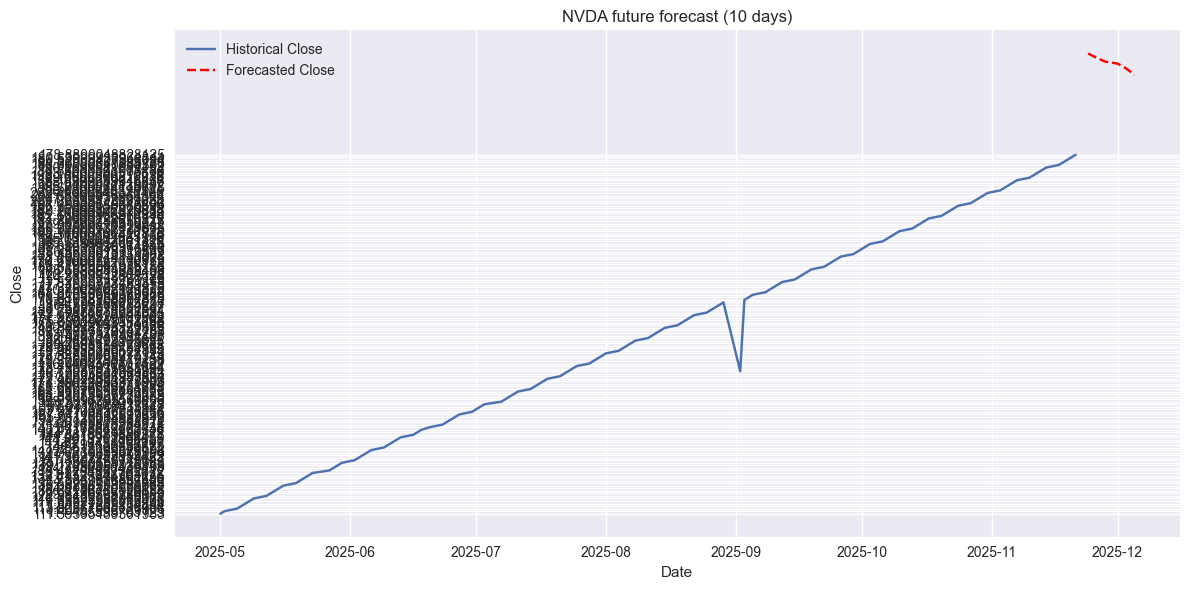

In [40]:
# 10. Future forecasting
# ============================
def forecast_future(model, scaler, close_scaled, steps=10, sequence_length=30, device="cpu"):
    model.eval()
    last_window = close_scaled[-sequence_length:]      # (seq_len, 1)
    window = torch.from_numpy(last_window).float().unsqueeze(0).to(device)
    future_scaled = []

    with torch.no_grad():
        for _ in range(steps):
            next_scaled = model(window)                # (1, 1)
            future_scaled.append(next_scaled.cpu().numpy())
            next_step = next_scaled.unsqueeze(1)       # (1, 1, 1)
            window = torch.cat([window[:, 1:, :], next_step], dim=1)

    future_scaled_arr = np.vstack(future_scaled)       # (steps, 1)
    future_closes = scaler.inverse_transform(future_scaled_arr)
    return future_closes

future_days = 10
future_closes = forecast_future(
    model=model,
    scaler=scaler,
    close_scaled=close_scaled,
    steps=future_days,
    sequence_length=sequence_length,
    device=device,
)

print("Future predicted closes:")
print(future_closes.reshape(-1))

last_date = close_prices.index[-1]
future_index = pd.bdate_range(start=last_date + pd.Timedelta(days=1),
                              periods=future_days)

plt.figure(figsize=(12, 6))
plt.plot(close_prices.index, close_prices["Close"], label="Historical Close")
plt.plot(future_index, future_closes.flatten(), "r--", label="Forecasted Close")
plt.title(f"{ticker} future forecast ({future_days} days)")
plt.xlabel("Date")
plt.ylabel("Close")      # <- label says Close now
plt.legend()
plt.tight_layout()
plt.show()

In [41]:
# Direction accuracy (up/down)
actual_diff = np.diff(y_test_price.flatten())
pred_diff   = np.diff(test_pred_price.flatten())
actual_dir = np.sign(actual_diff)
pred_dir   = np.sign(pred_diff)
direction_accuracy = np.mean(actual_dir == pred_dir) * 100
print(f"Direction accuracy (up/down): {direction_accuracy:.2f}%")

Direction accuracy (up/down): 45.45%
